<a href="https://colab.research.google.com/github/Razankenawy7/seam/blob/main/seam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Resized image saved to: /content/drive/MyDrive/resized.jpg


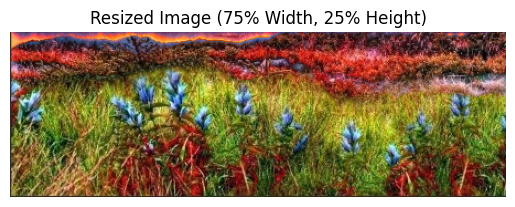

In [18]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import drive

def mount_drive():
    drive.mount('/content/drive', force_remount=True)
    filepath = "/content/drive/MyDrive/soraa.jpg"

    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Error: The file '{filepath}' was not found. Check the path in Google Drive.")

    return filepath

def compute_energy(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
    dx = np.abs(np.gradient(gray, axis=1))
    dy = np.abs(np.gradient(gray, axis=0))
    return dx + dy

def find_seam(energy):
    h, w = energy.shape
    seam_map = energy.copy()
    backtrack = np.zeros_like(seam_map, dtype=np.int32)

    for i in range(1, h):
        for j in range(w):
            left = seam_map[i - 1, j - 1] if j > 0 else np.inf
            up = seam_map[i - 1, j]
            right = seam_map[i - 1, j + 1] if j < w - 1 else np.inf
            min_energy = min(left, up, right)
            seam_map[i, j] += min_energy
            backtrack[i, j] = np.argmin([left, up, right]) - 1 + j

    seam = []
    j = np.argmin(seam_map[-1])
    for i in range(h - 1, -1, -1):
        seam.append(j)
        j = backtrack[i, j]

    return seam[::-1]

def remove_seam(image, seam):
    h, w, _ = image.shape
    new_image = np.zeros((h, w - 1, 3), dtype=np.uint8)
    for i in range(h):
        new_image[i, :, :] = np.delete(image[i, :, :], seam[i], axis=0)
    return new_image

def seam_carving(image, num_seams):
    seams_removed = []
    for _ in range(num_seams):
        energy = compute_energy(image)
        seam = find_seam(energy)
        seams_removed.append(seam)
        image = remove_seam(image, seam)
    return image, seams_removed

def resize_image(image, new_width, new_height):
    vertical_seams = []
    if new_width < image.shape[1]:
        image, vertical_seams = seam_carving(image, image.shape[1] - new_width)

    horizontal_seams = []
    if new_height < image.shape[0]:
        image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        image, horizontal_seams = seam_carving(image, image.shape[1] - new_height)
        image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

    return image, vertical_seams, horizontal_seams

if __name__ == "__main__":
    filepath = mount_drive()
    img = cv2.imread(filepath)

    if img is None:
        raise ValueError("Error: Unable to read the image. Check the file path and format.")

    new_width = int(img.shape[1] * 0.75)  # 75% of original width
    new_height = int(img.shape[0] * 0.25)  # 25% of original height
    resized_img, seams_v, seams_h = resize_image(img, new_width, new_height)

    output_resized = "/content/drive/MyDrive/resized.jpg"
    cv2.imwrite(output_resized, resized_img)

    print(f"Resized image saved to: {output_resized}")
    plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
    plt.title("Resized Image (75% Width, 25% Height)")
    plt.axis("off")
    plt.show()
